In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr,spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)

mask_file = '/Users/li/Desktop/template/Schaefer/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata()

nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
roi_name = list(nw_labels['ROI Name'])


brain_ISC_np.shape (200, 37, 37)


<Axes: >

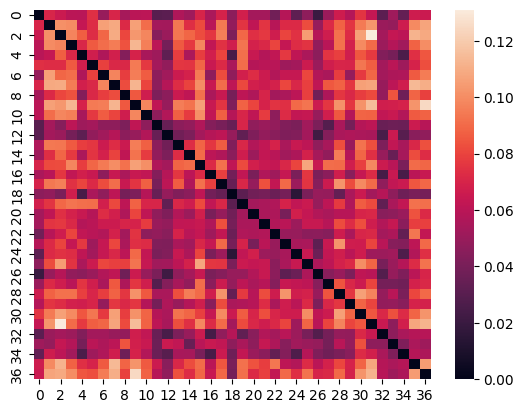

In [3]:

sub_list = list(range(13,51))
sub_list.remove(21)

subs_change_tr = []
for sub in sub_list:
    # time points
    sub_time_file = f'/Users/li/Desktop/task-debate/behavdata/during_scan/combined_6runs_filter_diff/subject_{sub}_rate_diff.csv'
    df = pd.read_csv(sub_time_file)
    change_time = list(df['time'][1:])
    tr = [round(x/2) for x in change_time]
    subs_change_tr.append(tr)


brain_ISC_np = np.zeros((200, 37, 37))

for i in range(37):
    for j in range(i, 37): 
        
        if i == j:
            brain_ISC_np[:,i, j] = 0 #对角线元素设为1
            continue
        
        #计算两人变化点的并集
        sub_i_tr = subs_change_tr[i]
        sub_j_tr = subs_change_tr[j]
        combined = sub_i_tr + sub_j_tr

        # 删除两人并集变化点前后10个tr数据
        delete_tr = sorted({i for x in combined for i in range(x - 5, x + 11)})
        delete_tr = [item for item in delete_tr if item < 1493]
        delete_tr = [item for item in delete_tr if item > 1]

        # 删除
        sub_i_data = all_brain_data[i,:,:]
        sub_j_data = all_brain_data[j,:,:]
        sub_i_data = np.delete(sub_i_data, delete_tr, axis=0)
        sub_j_data = np.delete(sub_j_data, delete_tr, axis=0)

        # 现在，sub_data 是TR数*200的二维数组，计算每个roi的相关
        correlations = np.array([pearsonr(sub_i_data[:,i], sub_j_data[:,i])[0] for i in range(sub_i_data.shape[1])])
        
        brain_ISC_np[:, i, j] = correlations
        brain_ISC_np[:, j, i] = correlations

print("brain_ISC_np.shape", brain_ISC_np.shape)

brain_ISC_Z_np = np.arctanh(brain_ISC_np)

sns.heatmap(brain_ISC_np.mean(0))


In [4]:
bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'

sub_list_num = list(range(13,51))
sub_list_num.remove(21)

time_points = list(range(0,3000,60)) + [2986]  # every 1 minute
# time_points = list(range(0,3000,120)) + [2986] # every 2 min
# time_points = list(range(0,3000,300)) + [2986] # every 5 min
# time_points = [0, 252, 500, 772, 1098, 1484, 1892, 2464, 2986] # every speaker
# time_points = list(range(0,2987,2)) # every TR

# time_points = [0,80,168,208,252, 
#                326,364,464,500,
#                538,588,686,772,
#                860,986,1026,1098,
#                1204,1250,1406,1484,
#                1578,1722,1810,1892,
#                1972,2114,2216,2464,
#                2628,2756,2986] 

all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
    
attitude = pd.DataFrame(all_subject_data)

start_attitude = pd.DataFrame(attitude)[0]
start_attitude_SM = -np.abs(start_attitude.values[:, np.newaxis] - start_attitude.values)

attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
print(attitude_change.shape)

attitude_change_distances = -pdist(attitude_change)
# attitude_change_distances = -np.sqrt(pdist(attitude_change))
# attitude_change_distances = -np.log(pdist(attitude_change))
attitude_change_SM = squareform(attitude_change_distances)
print(attitude_change_SM.shape)

# sns.heatmap(attitude_change_SM)


(37, 50)
(37, 37)


In [5]:

subjects = list(range(13,51))
subjects.remove(21)

personality = pd.read_csv('/Users/li/Desktop/task-debate/behavdata/questionire_data/personality.csv')

selected_data = personality[personality['sub'].isin(subjects)]
selected_data = selected_data.set_index('sub').loc[subjects]

ages = selected_data['age'].values
age_diff_matrix = np.abs(ages[:, np.newaxis] - ages)

sex = selected_data['sex'].values
sex_diff_matrix = np.abs(sex[:, np.newaxis] - sex)

IUS = selected_data['IUS'].values
joint_IUS = (IUS[:, np.newaxis] + IUS)/2



In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

def regress_out(vec, control_matrices, upper_triangle_indices, standardize):
    """
    对给定的向量进行回归，剥离控制变量的影响，先标准化再回归（可选）。
    
    参数:
    - vec: np.array, 待剥离影响的向量
    - control_matrices: list of np.array, 控制变量的矩阵列表
    - upper_triangle_indices: tuple, 矩阵上三角的索引
    - standardize: bool, 是否先标准化数据，默认值为 True
    
    返回:
    - residuals: np.array, 回归后的残差
    """
    if control_matrices is None or len(control_matrices) == 0:
        return vec  # 如果没有控制变量，直接返回原始向量
    
    # 如果需要标准化，先标准化 vec
    if standardize:
        scaler = StandardScaler()
        vec_scaled = scaler.fit_transform(vec.reshape(-1, 1)).flatten()
    else:
        vec_scaled = vec
    
    # 收集控制变量的标准化版本（如果需要）
    control_vectors = []
    for control_matrix in control_matrices:
        control_vec = control_matrix[upper_triangle_indices]
        if standardize:
            control_vec_scaled = scaler.fit_transform(control_vec.reshape(-1, 1)).flatten()
        else:
            control_vec_scaled = control_vec
        control_vectors.append(control_vec_scaled)
    
    # 拼接控制变量矩阵
    control_matrix = np.column_stack(control_vectors)

    # 执行回归
    model = LinearRegression().fit(control_matrix, vec_scaled)
    
    # 计算残差
    residuals = vec_scaled - model.predict(control_matrix)
    
    return residuals

def mantel_with_multiple_controls(matrix1, matrix2, control_matrices=None, corr_type='spearman', permutations=1000, tail=2, standardize=True):
    """
    执行带有多个控制变量的 Mantel Test，包含置换检验。
    
    参数:
    - matrix1: np.array, 第一个距离矩阵 (NxN)
    - matrix2: np.array, 第二个距离矩阵 (NxN)
    - control_matrices: list of np.array, 控制变量的矩阵列表（默认为 None）
    - permutations: int, 置换次数
    - tail: int, p值的类型，1 表示单尾，2 表示双尾
    
    返回:
    - r_obs: 观察到的 Pearson 或 Spearman 相关系数
    - p_value: 置换检验的 p 值
    """
    # 确保输入矩阵是方阵
    assert matrix1.shape == matrix2.shape, "两个矩阵的形状必须相同"
    assert matrix1.shape[0] == matrix1.shape[1], "输入必须是方阵"
    
    # 提取上三角部分（不包括对角线）
    upper_triangle_indices = np.triu_indices_from(matrix1, k=1)
    vec1 = matrix1[upper_triangle_indices]
    vec2 = matrix2[upper_triangle_indices]
    
    # 对每个控制矩阵进行回归，剥离控制变量的影响
    residuals1 = regress_out(vec1, control_matrices, upper_triangle_indices,standardize=standardize)
    residuals2 = regress_out(vec2, control_matrices, upper_triangle_indices,standardize=standardize)
    
    # 计算观察到的相关系数
    if corr_type == 'pearson':
        r_obs, _ = pearsonr(residuals1, residuals2)
    elif corr_type == 'spearman':
        r_obs, _ = spearmanr(residuals1, residuals2)
    
    # 进行置换检验
    permuted_r = []
    n = matrix1.shape[0]
    
    for _ in range(permutations):
        # 随机打乱行列索引
        perm_indices = np.random.permutation(n)
        
        # 重新排列矩阵
        perm_matrix2 = matrix2[np.ix_(perm_indices, perm_indices)]
        
        # 对每个控制变量矩阵也进行相同的置换（如果存在控制变量）
        perm_control_matrices = []
        if control_matrices is not None:
            for control_matrix in control_matrices:
                perm_control_matrix = control_matrix[np.ix_(perm_indices, perm_indices)]
                perm_control_matrices.append(perm_control_matrix)
        
        # 提取置换后的上三角部分
        perm_vec2 = perm_matrix2[upper_triangle_indices]
        
        # 对置换后的矩阵进行回归，剥离控制变量的影响
        perm_residuals2 = regress_out(perm_vec2, perm_control_matrices, upper_triangle_indices, standardize=standardize)
        
        # 计算置换后的相关系数
        if corr_type == 'pearson':
            r_perm, _ = pearsonr(residuals1, perm_residuals2)
        elif corr_type == 'spearman':
            r_perm, _ = spearmanr(residuals1, perm_residuals2)
        
        permuted_r.append(r_perm)
    
    # 计算双尾或单尾 p 值
    p_value = _calc_pvalue(np.array(permuted_r), r_obs, tail)
    
    return r_obs, p_value

def _calc_pvalue(all_p, stat, tail):
    """计算基于置换分布的 p 值
    
    参数：
    - all_p: 置换分布的相关系数列表
    - stat: 观察到的统计量（如统计结果中的相关系数）
    - tail: (int) 1 或 2，表示单尾或双尾 p 值
    
    返回：
    - p_value: 计算得到的 p 值
    """
    denom = float(len(all_p)) + 1
    if tail == 1:
        numer = np.sum(all_p >= stat) + 1 if stat >= 0 else np.sum(all_p <= stat) + 1
    elif tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    else:
        raise ValueError("tail 必须是 1 或 2")
    return numer / denom


In [7]:

rlist1, plist1 = [],[]
for roi in range(200):

    r, p = mantel_with_multiple_controls(attitude_change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='pearson',
                                        control_matrices = [start_attitude_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist1.append(r)
    plist1.append(p)

50,0.194,0.006299370062993701
89,0.263,0.0038996100389961006
171,0.186,0.030596940305969402
179,0.229,0.0117988201179882


In [8]:
rlist2, plist2 = [],[]
for roi in range(200):
    r, p = mantel_with_multiple_controls(attitude_change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='pearson',
                                        # control_matrices = [start_attitude_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist2.append(r)
    plist2.append(p)

50,0.200,0.007099290070992901
89,0.270,0.0022997700229977
97,0.203,0.0491950804919508
171,0.187,0.027197280271972803
179,0.231,0.016198380161983803


In [9]:
rlist3, plist3 = [],[]
for roi in range(200):
    r, p = mantel_with_multiple_controls(attitude_change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='spearman',
                                        control_matrices = [start_attitude_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist3.append(r)
    plist3.append(p)

50,0.174,0.0160983901609839
89,0.234,0.0053994600539946005
179,0.192,0.034396560343965606


In [10]:
rlist4, plist4 = [],[]
for roi in range(200):
    r, p = mantel_with_multiple_controls(attitude_change_SM, brain_ISC_Z_np[roi],
                                        standardize=True, corr_type='spearman',
                                        # control_matrices = [start_attitude_SM, sex_diff_matrix, age_diff_matrix], 
                                        permutations=10000,tail=2)
    if p <0.05:
        print(f'{roi},{r:.3f},{p}')

    rlist4.append(r)
    plist4.append(p)

50,0.173,0.016998300169983
89,0.236,0.006999300069993001


In [11]:
result_data = {
    'pearson control': rlist1,
    'p1': plist1,
    'pearson no-control': rlist2,
    'p2': plist2,
    'spearman control': rlist3,
    'p3': plist3,
    'spearman no-control': rlist4,
    'p4': plist4
}

result_data_df = pd.DataFrame(result_data)

result_data_df.to_csv('/Users/li/Desktop/debate2025/results/ISC-ISRSA-Exp1-discard-1min.csv', index=False)